In [1]:
import glob
import pickle
import numpy as np
from einops import rearrange, repeat
from torch.utils.data import random_split, DataLoader, Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
model_name = 'pca'

In [3]:
class VRTaskTrial:
    def __init__(
        self,
        session: str,
        neural: np.ndarray,
        position: np.ndarray,
        view_angle: np.ndarray,
        velocity: np.ndarray,
        angular_velocity: np.ndarray,
        masked: bool, cues: np.ndarray
    ):
        self.session = session
        self.neural = np.nan_to_num(neural)
        self.position = position
        self.view_angle = view_angle
        self.velocity = velocity
        self.angular_velocity = angular_velocity
        self.masked = masked
        self.cues = cues

    def num_neural_ts(self):
        return self.neural.shape[0]
    
    def num_neurons(self):
        return self.neural.shape[1]
    
    def num_behavioral_ts(self):
        return self.position.shape[0]

    def __len__(self):
        return self.neural.shape[0]

In [4]:
files = glob.glob('/home/hice1/smahato7/scratch/dop/data/' + '*.pkl')
data = []
for file in files:
    session_name = file.split('/')[-1].split('.')[0]
    session_obj = pickle.load(open(file, 'rb'))
    num_trials = session_obj['num_trials']
    print(num_trials, session_obj.keys())
    for trial in range(num_trials):
        trial_obj = VRTaskTrial(
            session=session_name,
            neural=session_obj['df'][trial],
            position=session_obj['position'][trial],
            view_angle=session_obj['view_angle'][trial],
            velocity=session_obj['velocity'][trial],
            angular_velocity=session_obj['angular_velocity'][trial],
            masked=session_obj['trial_mask'][trial],
            cues=session_obj['cue_onsets'][trial]
        )
        data.append(trial_obj)

122 dict_keys(['num_trials', 'df', 'cue_onsets', 'total_cues', 'position', 'view_angle', 'velocity', 'angular_velocity', 'rewarded', 'trial_mask'])
166 dict_keys(['num_trials', 'df', 'cue_onsets', 'total_cues', 'position', 'view_angle', 'velocity', 'angular_velocity', 'rewarded', 'trial_mask'])
136 dict_keys(['num_trials', 'df', 'cue_onsets', 'total_cues', 'position', 'view_angle', 'velocity', 'angular_velocity', 'rewarded', 'trial_mask'])
126 dict_keys(['num_trials', 'df', 'cue_onsets', 'total_cues', 'position', 'view_angle', 'velocity', 'angular_velocity', 'rewarded', 'trial_mask'])
165 dict_keys(['num_trials', 'df', 'cue_onsets', 'total_cues', 'position', 'view_angle', 'velocity', 'angular_velocity', 'rewarded', 'trial_mask'])
136 dict_keys(['num_trials', 'df', 'cue_onsets', 'total_cues', 'position', 'view_angle', 'velocity', 'angular_velocity', 'rewarded', 'trial_mask'])
211 dict_keys(['num_trials', 'df', 'cue_onsets', 'total_cues', 'position', 'view_angle', 'velocity', 'angular_ve

In [22]:
first_session_data = [d for d in data if d.session == data[0].session]

### PCA

In [23]:
def perform_trial_pca(neural_data, variance_threshold=0.90):
    # Mean-center the data
    data_for_pca = neural_data - np.mean(neural_data, axis=0, keepdims=True)  # Shape: (T, N)

    # Fit PCA
    pca_full = PCA()
    pca_full.fit(data_for_pca)

    # Determine number of components
    cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
    num_components = np.argmax(cumulative_variance >= variance_threshold) + 1

    # Fit PCA with selected number of components
    pca = PCA(n_components=num_components)
    latent_variables = pca.fit_transform(data_for_pca)

    return latent_variables, pca, num_components

In [25]:
def get_trial_splot(session, train_prop=0.8):
    shuffled_trials = np.random.permutation(session)
    num_train = int(len(shuffled_trials) * train_prop)
    train_trials = shuffled_trials[:num_train]
    test_trials = shuffled_trials[num_train:]
    return train_trials, test_trials

In [41]:
def linear_decode(pca, neural, covariate):
    best_r2 = -np.inf
    best_pred = None
    
    neural = np.nan_to_num(neural)
    centered_neural = neural - np.mean(neural, axis=0, keepdims=True)
    latent_vars = pca.transform(neural)

    X = latent_vars
    y = covariate
    model = LinearRegression()
    model.fit(X, y)

    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    if r2 > best_r2:
        best_r2 = r2
        best_pred = y_pred
    
    return best_r2, best_pred

def decode_trials(trials, pca_model, covariate_name, progress=True):
    r2_vals = []
    pred_vals = []
    covariates = []
    it = tqdm(trials) if progress else trials
    for trial in it:
        r2, pred = linear_decode(pca_model, trial.neural[:-45,:], trial.__dict__[covariate_name])
        r2_vals.append(r2)
        pred_vals.append(pred)
        covariates.append(trial.__dict__[covariate_name])
    return r2_vals, pred_vals, covariates

In [43]:
def pca_decode_multiple(session, covariate_name, times=10):
    all_train_r2s = []
    all_test_r2s = []
    all_n_components = []
    for _ in tqdm(range(times)):
        train_trials, test_trials = get_trial_splot(session)
        train_neural = np.concatenate([trial.neural[:-45,:] for trial in train_trials], axis=0)
        latent_vars_train, pca_model_train, n_components = perform_trial_pca(train_neural, variance_threshold=0.90)
        train_r2s, train_cov_preds, train_cov_gt = decode_trials(train_trials, pca_model_train, covariate_name, progress=False)
        test_r2s, test_cov_preds, test_cov_gt = decode_trials(test_trials, pca_model_train, covariate_name, progress=False)
        all_train_r2s.append(np.mean(train_r2s))
        all_test_r2s.append(np.mean(test_r2s))
        all_n_components.append(n_components)
    return np.mean(all_train_r2s), np.mean(all_test_r2s), np.mean(all_n_components), train_cov_preds, train_cov_gt, test_cov_preds, test_cov_gt

In [47]:
train_pos_r2, test_pos_r2, n_components_pos, train_pos_preds, train_pos_gt, test_pos_preds, test_pos_gt = pca_decode_multiple(first_session_data, 'position', times=30)
print(f"Position | Num Components: {n_components_pos} | Train R2: {train_pos_r2} | Test R2: {test_pos_r2}")

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:33<00:00,  1.12s/it]

Position | Num Components: 11.033333333333333 | Train R2: 0.7215838274379415 | Test R2: 0.7204045365065976


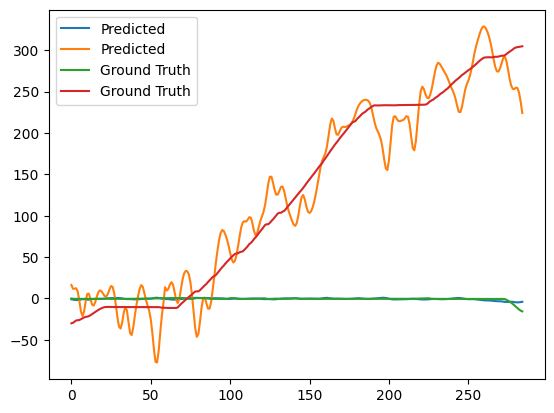

In [56]:
trial = 32
plt.plot(train_pos_preds[trial], label='Predicted')
plt.plot(train_pos_gt[trial], label='Ground Truth')
plt.legend()
plt.show()

In [45]:
train_va_r2, test_va_r2, n_components_va, train_va_preds, train_va_gt, test_va_preds, test_va_gt = pca_decode_multiple(first_session_data, 'view_angle', times=30)
print(f"View Angle | Num Components: {n_components_va} | Train R2: {train_va_r2} | Test R2: {test_va_r2}")

100%|██████████| 10/10 [00:13<00:00,  1.39s/it]

View Angle | Num Components: 11.2 | Train R2: 0.6930051330735642 | Test R2: 0.6925154901378953


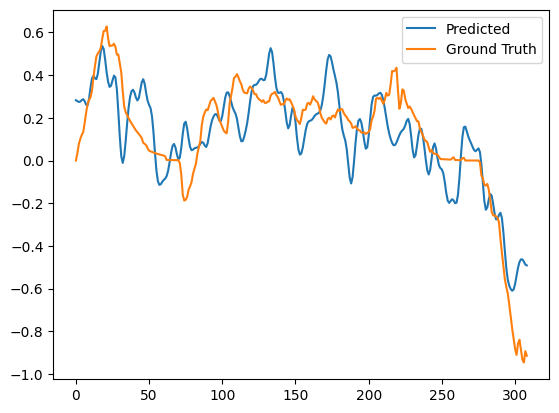

In [59]:
trial = 49
plt.plot(train_va_preds[trial], label='Predicted')
plt.plot(train_va_gt[trial], label='Ground Truth')
plt.legend()
plt.show()

In [60]:
# Velocity
train_vel_r2, test_vel_r2, n_components_vel, train_vel_preds, train_vel_gt, test_vel_preds, test_vel_gt = pca_decode_multiple(first_session_data, 'velocity', times=30)
print(f"Velocity | Num Components: {n_components_vel} | Train R2: {train_vel_r2} | Test R2: {test_vel_r2}")

100%|██████████| 30/30 [00:31<00:00,  1.07s/it]

Velocity | Num Components: 11.066666666666666 | Train R2: 0.586229991833489 | Test R2: 0.5863981683985711


### Across all sessions

In [73]:
def extract_results_across_sessions(covariate_names, session_results, times_each=10):
    session_names = set([d.session for d in data])
    for session_name in session_names:
        session_data = [d for d in data if d.session == session_name]
        if session_name not in session_results:
            session_results[session_name] = {}

        for covariate_name in covariate_names:
            print(f"Session: {session_name} | Covariate: {covariate_name}")
            if covariate_name in session_results[session_name]:
                print("Skipping...")
                continue
            train_r2, test_r2, n_components, train_preds, train_gt, test_preds, test_gt = pca_decode_multiple(session_data, covariate_name, times=times_each)
            session_results[session_name][covariate_name] = {
                'train_r2': train_r2,
                'test_r2': test_r2,
                'n_components': n_components,
                'train_preds': train_preds,
                'train_gt': train_gt,
                'test_preds': test_preds,
                'test_gt': test_gt
            }
            print(f"Num Components: {n_components} | Train R2: {train_r2} | Test R2: {test_r2}")
            print()

In [8]:
filename = f'/home/hice1/smahato7/dop/notebooks/output/{model_name}/session_results.pkl'
session_results = {}
try:
    with open(filename, 'rb') as f:
        session_results = pickle.load(f)
        print("Loaded previous results.")
        print(f"Saved covariates: {', '.join(session_results[list(session_results.keys())[0]].keys())}")
except FileNotFoundError:
    print("No previous results found, starting fresh.")

Loaded previous results.
Saved covariates: position, view_angle, velocity, angular_velocity


In [9]:
covariate_names = ['position', 'view_angle', 'velocity', 'angular_velocity']
extract_results_across_sessions(covariate_names, session_results, times_each=20)

NameError: name 'extract_results_across_sessions' is not defined

### Post-hoc analysis

In [70]:
for session_name, session_data in session_results.items():
    print(f"Session: {session_name}")
    has_negatives = False
    for covariate_name, covariate_data in session_data.items():
        if has_negatives or covariate_data['train_r2'] < 0 or covariate_data['test_r2'] < 0:
            has_negatives = True
            assert covariate_data['train_r2'] < 0 and covariate_data['test_r2'] < 0
    if not has_negatives:
        print(f"All good! {[d for d in data if d.session == session_name][0].neural.shape[1]}")
    else:
        print(f"Some negative R2s found! {[d for d in data if d.session == session_name][0].neural.shape[1]}")

Session: 151_1-17-18
All good! 15
Session: 14972_3-10-16
All good! 18
Session: 14974_3-8-16
All good! 23
Session: 803_2-22-17
All good! 17
Session: 697_12-7-16
All good! 19
Session: 145_1-23-18
Some negative R2s found! 12
Session: 147_1-19-18
Some negative R2s found! 4
Session: 927_8-2-17
Some negative R2s found! 13
Session: 14985_6-15-16
All good! 9
Session: 947_10-10-17_take_2_new_position
All good! 9
Session: 150_1-16-18
All good! 11
Session: 1003_1-7-18
All good! 7
Session: 556_8-9-16
All good! 20
Session: 5330_8-1-16_take_2
All good! 9
Session: 946_9-18-17
Some negative R2s found! 3
Session: 802_5-31-17
All good! 18
Session: 150_1-22-18
All good! 7
Session: 801_3-30-17
All good! 13
Session: 151_1-18-18
Some negative R2s found! 10
Session: 161_4-7-17
All good! 24
Session: 947_8-31-17
Some negative R2s found! 12
Session: 131_1-8-18
All good! 6
Session: 651_11-7-16
All good! 24


In [ ]:
pickle.dump(session_results, open(filename, 'wb'))

In [14]:
def average_results_across_sessions(session_results):
    avg_results = {}
    for session_name, session_data in session_results.items():
        for covariate_name, covariate_data in session_data.items():
            if covariate_name not in avg_results:
                avg_results[covariate_name] = {
                    'train_r2': [],
                    'test_r2': []
                }
            if covariate_data['train_r2'] > 0:
                avg_results[covariate_name]['train_r2'].append(max(0, covariate_data['train_r2']))
                avg_results[covariate_name]['test_r2'].append(max(0, covariate_data['test_r2']))
    for covariate_name, covariate_data in avg_results.items():
        avg_results[covariate_name]['train_r2'] = np.mean(covariate_data['train_r2'])
        avg_results[covariate_name]['test_r2'] = np.mean(covariate_data['test_r2'])
    return avg_results

avg_results = average_results_across_sessions(session_results)
# pretty print it
for covariate_name, covariate_data in avg_results.items():
    print(f"Covariate: {covariate_name} | Train R2: {covariate_data['train_r2']} | Test R2: {covariate_data['test_r2']}")

Covariate: position | Train R2: 0.7117254181319119 | Test R2: 0.7104304446079027
Covariate: view_angle | Train R2: 0.6712805104243063 | Test R2: 0.6715339345259531
Covariate: velocity | Train R2: 0.6021149248369014 | Test R2: 0.6007026517875327
Covariate: angular_velocity | Train R2: 0.23961818730878653 | Test R2: 0.24042914903278428
